In [1]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

Let's load the data from the glasses MongoDB snapshot and take a look at the data fields we have to work with

In [2]:
with open('captivateFiltered.json') as f: data = json.load(f)

print(len(data),'\n')

for k in data[0]:
    print(k,':', data[0][k])

665669 

_id : {'$oid': '601c314ce5a2b222d4d9228f'}
source : 10.29.209.147
serverTimestamp : 1612460364733
blink_data : ExQTExMVFBYWFxgZGRoZGhkaGRkYGRgYFxgXGBcYFhYVFBMTExQUFRUWFhgYGRkaGRoZGhkZGBkYGBcYFxgXFxYWFBQTExMUFBUV
blink_tick_ms : 1516468294
blink_payload_ID : 1517244999
temple_temp : 26695
temple_therm : 24939
temple_tick_ms : 1517244999
nose_temp : 21063
nose_therm : 22887
nose_tick_ms : 1483176006
temp_sec_tick_ms : 1499677255
temp_sec_epoch : 1449359430
quatI : 7.929189166748675e+34
quatJ : 6.310779645437294e+34
quatK : 12.082337379455566
quatReal : 12.078431129455566
quatRadianAccuracy : 12.078431129455566
rot_tick_ms : 1094795585
activityConfidence : AAAAAAAAA
tick_ms_activity : 1094795585
pos_x : 12.078431129455566
pos_y : 12.078431129455566
pos_z : 12.078431129455566
pos_accuracy : 12.078431129455566
tick_ms_pos : 1094795585
pos_epoch : 1094795585
packet_tick_ms : 1094795585
packet_epoch : 1094795585


So now we need to get the data in a useful state.  Turns out we have 'ticks' which are based on the internal
clock from the MCU (will be very accurate relative to each other) as well as server timestamps (will not be, but
will be close).  

The tick values are not grounded in real time in any way, so we need to associate them to the server timestamp
to get useful timestamp values.

A few tricky things-- sometimes the pushes to the server buffers, so a server timestamp can have the *exact*
same value over many tick values.  Also, because of this, we need to be a little generous when dividing the
glasses into sessions (uninterrupted usage periods).

The ticks should be monotonically increasing until the glasses reset, which can happen if someone turns them
off and on.  

Mongo makes no guarantees about sorting, so we sort by server timestamp, then sort by ticks as a first step.  
When there is a break of several seconds in data or the tick count starts over, we break it into a new 
'session'.  We have a function to filter these sessions for just the useful chunks (>5 min), and to grab
sessions by the day they occurred using the server timestamp. (Since we're running tests on individuals per day).
                                    
Once we've filtered them into sessions, we've built helper functions that take in sessions and grab/process relevant data, i.e. they (1) map the tick to a timestamp, assuming correspondence between the first tick and server timestamp, including for blink data that needs one timestamp mapped to 100 timestamps, and (2) grab/process the relevant data for position and blinks, which requires some basic transformation to get workable data.  Once we've stripped out these minimal/useful parts of the data, we also have helper functions to plot them.

In [3]:
#filter on serverTimestamp
#plot based on ticks (on device ms clock, most accurate, blinks are 1kHz moving back from last sample)

# temp_sec_tick_ms
# temple_tick_ms
# packet_tick_ms
# serverTimestamp
# rot_tick_ms
# tick_ms_pos
# temp_sec_epoch


## HELPERS
flatten = lambda t: [item for sublist in t for item in sublist]

def tick_to_timestamp_ms_converter(tick_ref, timestamp_ms_ref):
    return lambda tick_val: timestamp_ms_ref + tick_val - tick_ref
    
def string_to_timestamp_ms(datestring):
    return datetime.strptime(datestring, '%m/%d/%y %I:%M:%S%p %Z').timestamp()*1000

def timestamp_ms_to_string(timestamp):
    local_tz = datetime.now().astimezone().tzinfo
    return datetime.fromtimestamp(timestamp/1000, tz=local_tz).strftime('%m/%d/%y %I:%M:%S%p %Z')

## GENERAL PACKET MANIPULATION
def get_packets_by_range(start="01/01/01 01:01:01AM EST", end=np.inf):
    #accepts timestamp string or timestamp value in ms; returns ordered packets by servertimestamp
    if type(start) == str: start = string_to_timestamp_ms(start)
    if type(end) == str: end = string_to_timestamp_ms(end)
    return sorted([x for x in data if x['serverTimestamp']>=start and x['serverTimestamp']<=end], key=lambda k: k['serverTimestamp'])

def create_sessions(packets, thresh_sec=5):
    #accepts list of sorted packets, breaks into sessions when: 
    # (1) we fail to see data from the server for >=thresh sec
    # (2) we see a packet_tick_ms descend instead of ascend
    
    final_packet_array_of_arrays = []
    current_session = []
    current_timestamp_packets = [packets[0]]
    
    last_seen = packets[0]['serverTimestamp']
    last_tick = packets[0]['packet_tick_ms']
    
    for packet in packets:
        #duplicate packet
        if packet['serverTimestamp'] == last_seen and packet['packet_tick_ms'] == last_tick:
            pass 
        #packet that is at the same server time, but is increasing packet_tick from prev servertime
        elif packet['serverTimestamp'] == last_seen and packet['packet_tick_ms'] > last_tick and packet['packet_tick_ms'] < last_tick + thresh_sec*1000:
            current_timestamp_packets.append(packet)
        #packet that is increased server time and packet tick
        elif packet['serverTimestamp'] > last_seen and packet['packet_tick_ms'] > last_tick and packet['packet_tick_ms'] < last_tick + thresh_sec*1000:
            current_session.extend(sorted(current_timestamp_packets, key=lambda k: k['packet_tick_ms']))
            current_timestamp_packets = [packet]
            last_seen = packet['serverTimestamp']
            last_tick = current_session[-1]['packet_tick_ms']
        #packet that has not increased servertime or not increased packettime within threshold 
        else:
            #print('new session: ', last_seen, packet['serverTimestamp'], last_tick, packet['packet_tick_ms'])
            if len(current_session) > 10:
                final_packet_array_of_arrays.append(current_session)
            current_session = []
            current_timestamp_packets = [packet]
            last_seen = packet['serverTimestamp']
            last_tick = packet['packet_tick_ms']
 
    if len(current_session) > 10:
        final_packet_array_of_arrays.append(current_session)
    
    return final_packet_array_of_arrays
    
def filter_short_sessions(sessions, min_thresh=5):
    return [session for session in sessions if (session[-1]['serverTimestamp'] - session[0]['serverTimestamp']) > min_thresh*60*1000]
    
def get_sessions_by_day(sessions, day="03/29"):
    return [session for session in sessions if timestamp_ms_to_string(session[0]['serverTimestamp']).startswith(day)]
    
def print_session_times(sessions):
    last_day = ''
    total_time = None
    #separate days and print in groups by day
    for i, session in enumerate(sessions):
        session_day = timestamp_ms_to_string(session[0]['serverTimestamp'])[:8]
        if session_day != last_day:
            if total_time is None: total_time = 0
            else:
                print('\n\t total time spent: %02d:%02d' % (total_time // 60, total_time % 60))
                total_time = 0
            
            last_day = session_day
            print('\n',session_day,'------')
        
        duration = (session[-1]['serverTimestamp'] - session[0]['serverTimestamp'])/(60*1000)
        duration_string = "duration=%02d:%02d" % (duration // 60, duration % 60)
        total_time += duration
                      
        print('\t', timestamp_ms_to_string(session[0]['serverTimestamp']), 'to', timestamp_ms_to_string(session[-1]['serverTimestamp']), '\t', duration_string)
    
    print('\n\t total time spent: %02d:%02d' % (total_time // 60, total_time % 60))
                
def blink_timestamp_to_array(timestamp_ms, num_points=100, Fs=1000):
    T_ms = (1000./Fs)
    start_time = timestamp_ms - ((num_points-1) * T_ms)
    return [start_time + T_ms*i for i in range(0, num_points)]
    
def blink_string_to_array(string):
    return struct.unpack('<200B', string.encode('UTF-16-LE'))[::2] #'UTF-16-LE'
    

## GET SPECIFIC DATA TYPE
def get_blink_data(data):
    #remove any packets without blinkdata
    data = [d for d in data if len(d['blink_data']) == 100]
    
    #associate first packet timestamp with tick to give us a tick to timestamp converter function
    tick_to_timestamp_fn = tick_to_timestamp_ms_converter(data[0]['blink_tick_ms'], data[0]['serverTimestamp'])
    
    #grab data and associated timestamp/ticks
    times = [blink_timestamp_to_array(tick_to_timestamp_fn(d['blink_tick_ms'])) for d in data]
    blink_data = [blink_string_to_array(d['blink_data']) for d in data]

    return flatten(times), flatten(blink_data)

def get_temp_data(data):
    #remove any packets without tempdata
    data = [d for d in data if (d['temple_tick_ms'] != 0 and d['nose_tick_ms'] != 0)]
    
    #associate first packet timestamp with tick to give us a tick to timestamp converter function
    tick_to_timestamp_fn = tick_to_timestamp_ms_converter(data[0]['temple_tick_ms'], data[0]['serverTimestamp'])
    
    #grab data and associated timestamp/ticks
    temple_times = [tick_to_timestamp_fn(d['temple_tick_ms']) for d in data]
    temple_data = [d['temple_temp'] for d in data]
    nose_times = [tick_to_timestamp_fn(d['nose_tick_ms']) for d in data]
    nose_data = [d['nose_temp'] for d in data]
    
    return temple_times, temple_data, nose_times, nose_data 

def get_quat_data(data):
    #remove any packets without quatdata
    data = [d for d in data if (d['rot_tick_ms'] != 0)]
    
    #associate first packet timestamp with tick to give us a tick to timestamp converter function
    tick_to_timestamp_fn = tick_to_timestamp_ms_converter(data[0]['rot_tick_ms'], data[0]['serverTimestamp'])
    
    #grab data and associated timestamp/ticks
    times = [tick_to_timestamp_fn(d['rot_tick_ms']) for d in data]
    I_data = [d['quatI'] for d in data]
    J_data = [d['quatJ'] for d in data]
    K_data = [d['quatK'] for d in data]
    real_data = [d['quatReal'] for d in data]
    accuracy_data = [d['quatRadianAccuracy'] for d in data]
    
    return times, I_data, J_data, K_data, real_data, accuracy_data  

def get_pos_data(data):
    #remove any packets without posdata
    data = [d for d in data if (d['pos_tick_ms'] != 0)]
    
    #associate first packet timestamp with tick to give us a tick to timestamp converter function
    tick_to_timestamp_fn = tick_to_timestamp_ms_converter(data[0]['tick_ms_pos'], data[0]['serverTimestamp'])
    
    #grab data and associated timestamp/ticks
    times = [tick_to_timestamp_fn(d['tick_ms_pos']) for d in data]
    x_data = [d['pos_x'] for d in data]
    y_data = [d['pos_y'] for d in data]
    z_data = [d['pos_z'] for d in data]
    accuracy_data = [d['pos_accuracy'] for d in data]
    
    return times, x_data, y_data, z_data, accuracy_data 


## PLOT DATA

def plot_quat(quatdata):
    times, I_data, J_data, K_data, real_data, accuracy_data = quatdata
    
    fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(16,4))
    ax.plot(times, I_data, label='I')
    ax.plot(times, J_data, label='J')
    ax.plot(times, K_data, label='K')
    ax.set(xlabel='timestamp (ms)', ylabel='quat vals',
       title='Quaternians Data')
    ax1.plot(times, real_data)
    ax1.set(xlabel='timestamp (ms)', ylabel='quat magnitude',
       title='Quaternians Magnitude Data')
    ax1.grid()
    fig.tight_layout()
    plt.show()

def plot_pos(posdata):
    times, x_data, y_data, z_data, accuracy_data = posdata
    
    fig, ax = plt.subplots(figsize=(16,4))
    ax.plot(times, x_data, label='x')
    ax.plot(times, y_data, label='y')
    ax.plot(times, z_data, label='z')
    ax.set(xlabel='timestamp (ms)', ylabel='pos data',
       title='Pos Data')
    ax.grid()
    fig.tight_layout()
    plt.show()

def plot_temp(tempdata):
    temple_times, temple_data, nose_times, nose_data = tempdata
    
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,4))
    ax[0].plot(temple_times, temple_data)
    ax[0].set(xlabel='timestamp (ms)', ylabel='temp',
       title='Temple Data')
    ax[0].grid()
    
    ax[1].plot(nose_times, nose_data)
    ax[1].set(xlabel='timestamp (ms)', ylabel='temp',
       title='Nose Data')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

def plot_blink(blinkdata):
    times, data = blinkdata
    
    fig, ax = plt.subplots(figsize=(16,4))
    ax.plot(times, data)
    ax.set(xlabel='timestamp (ms)', ylabel='raw blink value (8b)',
       title='Blink Data')
    ax.grid()
    plt.show()

def plot_blink_secs(blinkdata, numplots=10, secs=60, Fs=1000):
    times, data = blinkdata
    
    tvals = [times[i*(Fs*secs):(i+1)*(Fs*secs)] for i in range(numplots)]
    dvals = [data[i*(Fs*secs):(i+1)*(Fs*secs)] for i in range(numplots)]
    
    fig, axes = plt.subplots(nrows=numplots, figsize=(16,4*numplots))
    for i in range(numplots):
        axes[i].plot(tvals[i], dvals[i])
        axes[i].grid()
        axes[i].set(ylabel='raw blink value (8b)')
    
    axes[0].set(title='Blink Data ' + str(secs) + ' sec each')
    axes[numplots-1].set(xlabel='timestamp (ms)')
        
    plt.show()    

In [11]:
print(string_to_timestamp_ms('03/24/21 6:05:00PM EST'),'should equal 161662350000 if the code is right.')

#grab packets from a certain range (accepts timestamp ints in ms or datestrings of this form)
sorted_data = get_packets_by_range(start="03/24/21 12:00:00PM EST")

#sort them into sessions and see how many sessions we got
data_by_session = create_sessions(sorted_data)
total_num_sessions = len(data_by_session)

#filter out the sessions that are less than 5 min
data_by_session = filter_short_sessions(data_by_session)
print(len(data_by_session),'sessions found. (%d short sessions filtered.)' % (total_num_sessions - len(data_by_session)))

#print the session information by day
print_session_times(data_by_session)

1616623500000.0 should equal 161662350000 if the code is right.
9 sessions found. (10 short sessions filtered.)

 03/24/21 ------
	 03/24/21 04:10:28PM EDT to 03/24/21 04:22:03PM EDT 	 duration=00:11
	 03/24/21 04:25:50PM EDT to 03/24/21 06:47:50PM EDT 	 duration=02:21

	 total time spent: 02:33

 03/25/21 ------
	 03/25/21 02:25:13PM EDT to 03/25/21 05:55:40PM EDT 	 duration=03:30
	 03/25/21 06:11:11PM EDT to 03/25/21 08:32:30PM EDT 	 duration=02:21

	 total time spent: 05:51

 03/29/21 ------
	 03/29/21 03:28:19PM EDT to 03/29/21 04:07:45PM EDT 	 duration=00:39
	 03/29/21 04:10:38PM EDT to 03/29/21 05:48:17PM EDT 	 duration=01:37
	 03/29/21 05:51:01PM EDT to 03/29/21 06:49:15PM EDT 	 duration=00:58
	 03/29/21 06:49:41PM EDT to 03/29/21 07:27:35PM EDT 	 duration=00:37
	 03/29/21 07:29:10PM EDT to 03/29/21 08:01:04PM EDT 	 duration=00:31

	 total time spent: 04:25



 03/29/21 ------
	 03/29/21 03:28:19PM EDT to 03/29/21 04:07:45PM EDT 	 duration=00:39
	 03/29/21 04:10:38PM EDT to 03/29/21 05:48:17PM EDT 	 duration=01:37
	 03/29/21 05:51:01PM EDT to 03/29/21 06:49:15PM EDT 	 duration=00:58
	 03/29/21 06:49:41PM EDT to 03/29/21 07:27:35PM EDT 	 duration=00:37
	 03/29/21 07:29:10PM EDT to 03/29/21 08:01:04PM EDT 	 duration=00:31

	 total time spent: 04:25


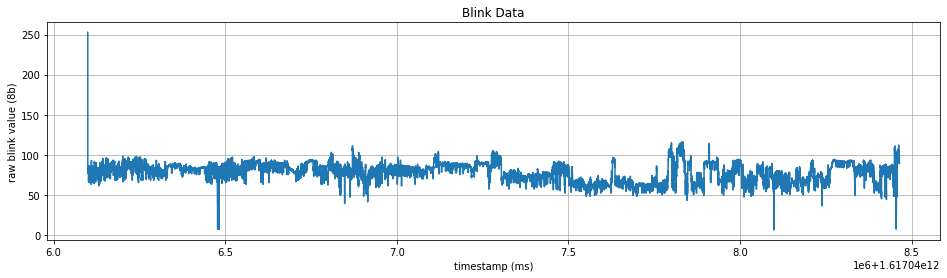

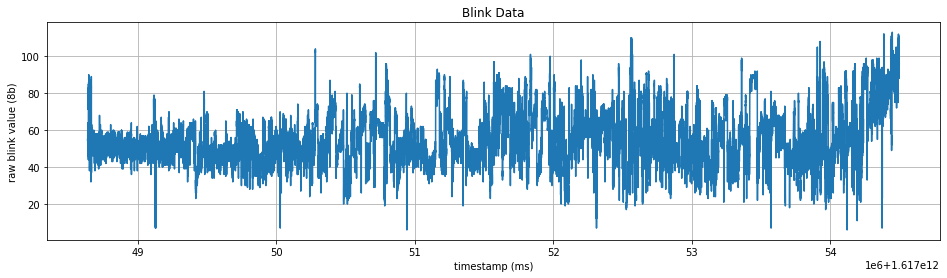

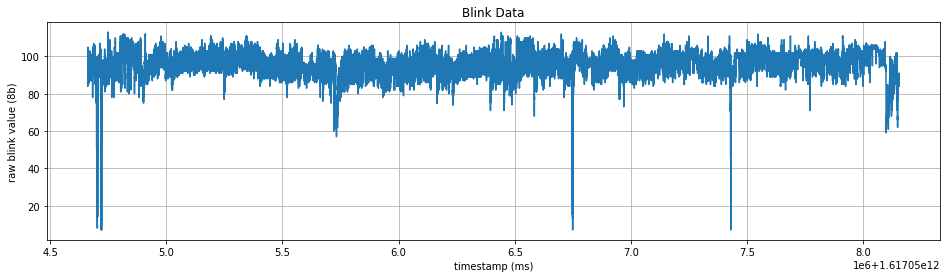

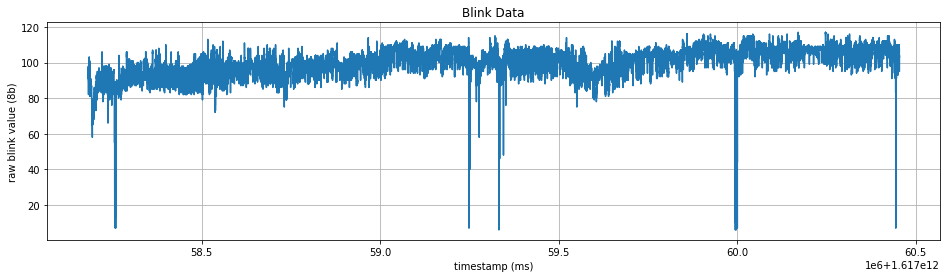

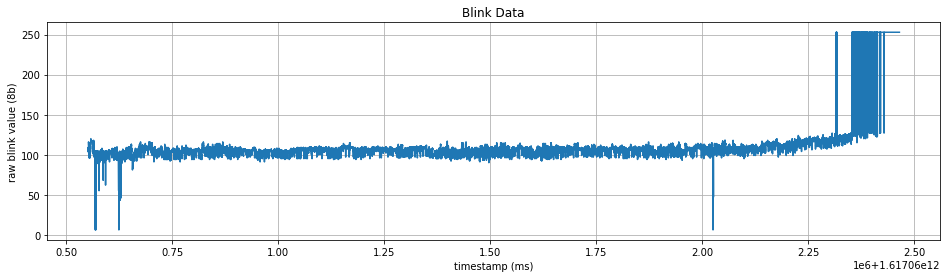

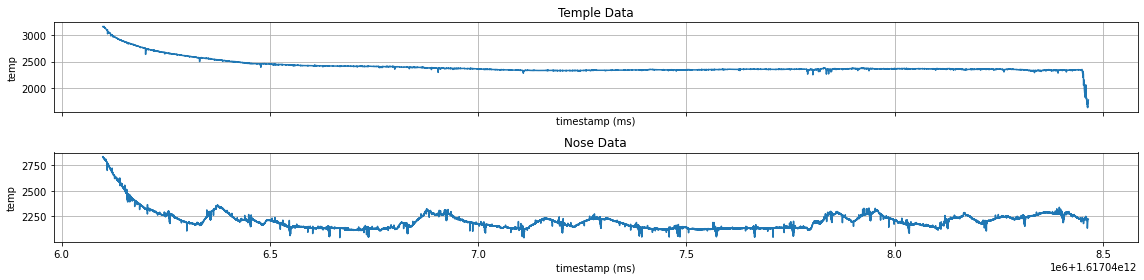

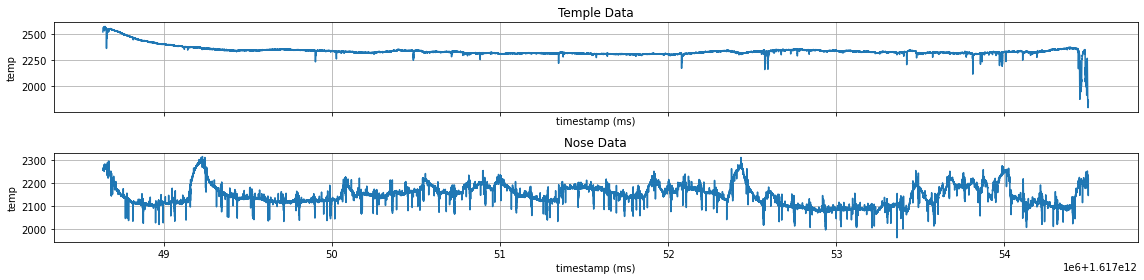

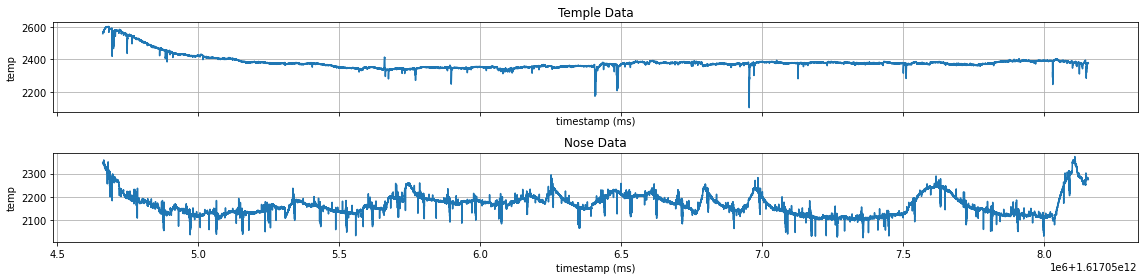

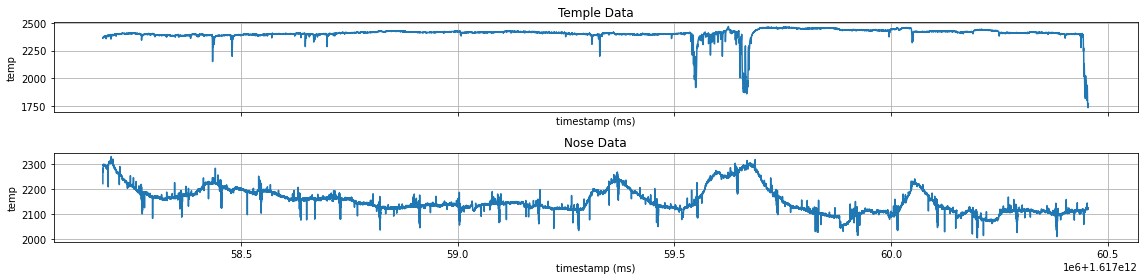

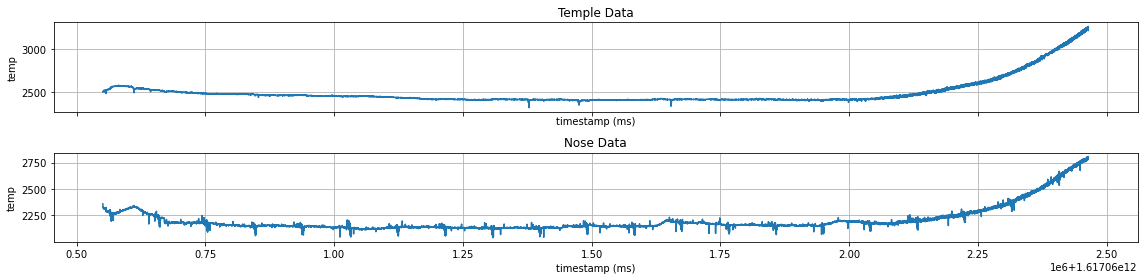

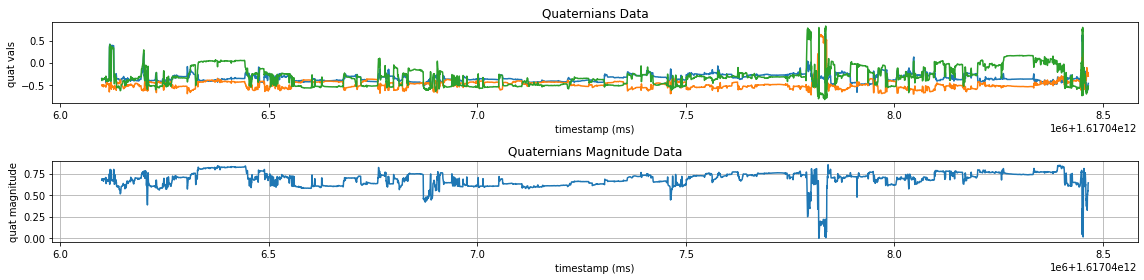

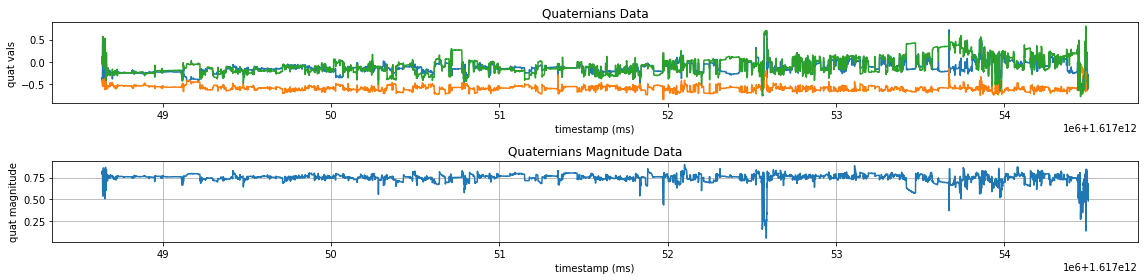

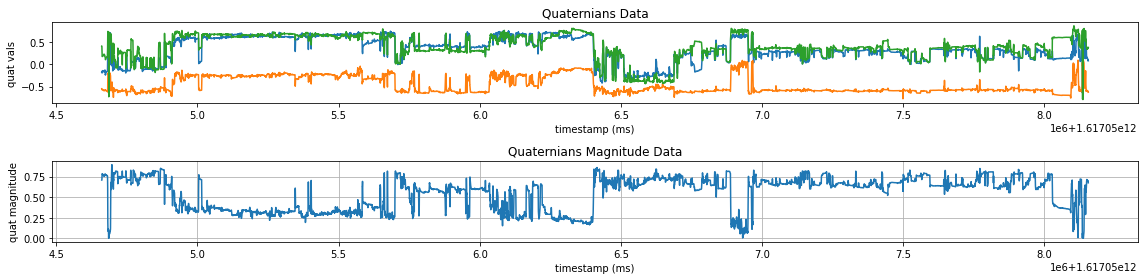

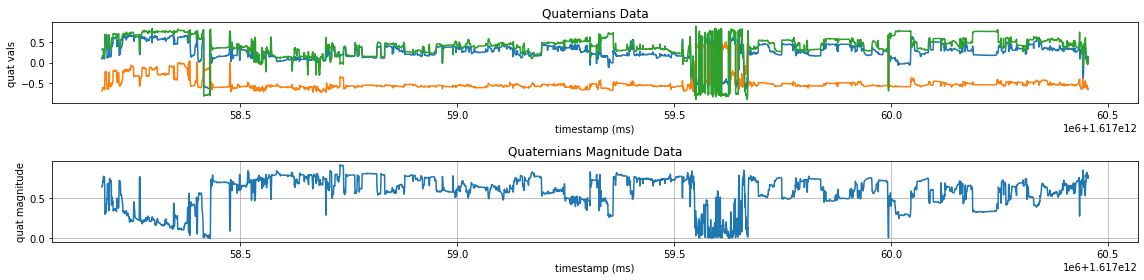

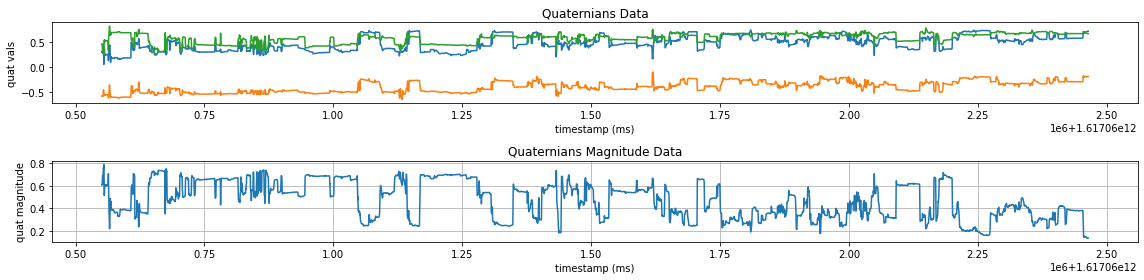

[None, None, None, None, None]

In [12]:
#rawblinkdata = get_blink_data(sorted_data)
#plot_blink(rawblinkdata)
#plot_blink_secs(rawblinkdata, 10, 45) # 3 plots of 45 sec worth of data each, starting from beginning

#rawtempdata = get_temp_data(sorted_data)
#plot_temp(rawtempdata)

#rawposdata = get_pos_data(sorted_data)
#plot_pos(rawposdata)

#rawquatdata = get_quat_data(sorted_data)
#for d in rawquatdata[0][:1000]: print(d)
#plot_quat(rawquatdata)


data_by_session = get_sessions_by_day(data_by_session, "03/29")
print_session_times(data_by_session)

blinkdata_sessions = [get_blink_data(d) for d in data_by_session]
[plot_blink(blinkdata) for blinkdata in blinkdata_sessions]

tempdata_sessions = [get_temp_data(d) for d in data_by_session]
[plot_temp(tempdata) for tempdata in tempdata_sessions]

quatdata_sessions = [get_quat_data(d) for d in data_by_session]
[plot_quat(quatdata) for quatdata in quatdata_sessions]


## Additional Code

This is early code to try and deal with large video csvs; we've since added a pipeline so we
can store everything in memory and don't have to worry about chunking up the giant raw video files


 03/25/21 ------
	 03/25/21 02:25:13PM EDT to 03/25/21 05:55:40PM EDT 	 duration=03:30
	 03/25/21 06:11:11PM EDT to 03/25/21 08:32:30PM EDT 	 duration=02:21

	 total time spent: 05:51
grabbing glasses data...


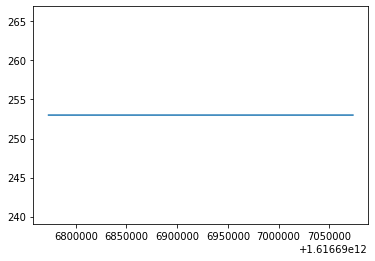

grabbing video data...
got 5.00 min of glasses data, and 6.96 min of video data, where the video is offset -0.96 min.


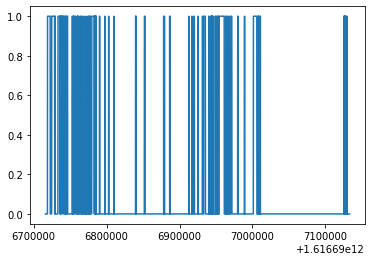

grabbing glasses data...


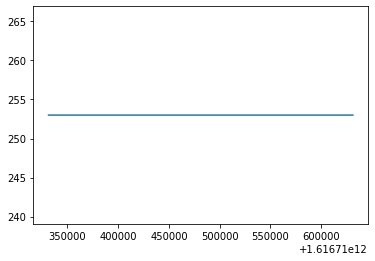

grabbing video data...
got 5.00 min of glasses data, and 3.78 min of video data, where the video is offset -0.73 min.


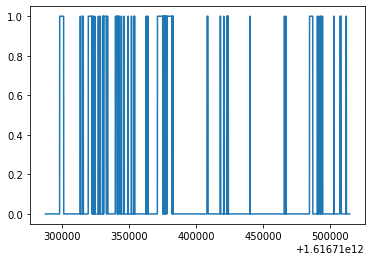

In [74]:
# want to grab data similar to session from video.csv
# we will grab based on timestamp +- some value you can enter.
# this offset will need to be decided based on blink alignment


def get_session_timestamps_ms(sessions, index=None):
    return [[session[0]['serverTimestamp'], session[-1]['serverTimestamp']] for session in sessions] 



def grab_pandas_vid_between_timestamps_ms_by_chunk(csv_filename, 
                                          gopro_timestamp_fnc, 
                                          start_timestamp, 
                                          end_timestamp,
                                          fps=60
                                         ):
    #grab relevant frames/columns between timestamps, given timestamp mapping function
    #return a df with timestamp, timestamp_est, AU45_r, AU45_c, pose_Rx, pose_Ry, poseR_z

    
    chunksize = 3600 #one min at 60fps
    video_df = pd.DataFrame() 

    with pd.read_csv(csv_filename, delimiter=', ', engine='python', chunksize=chunksize) as reader:
        for chunk in reader:
            print(gopro_timestamp_fnc(chunk['timestamp'].iloc[0]), start_timestamp, end_timestamp)
            #if any values in our range
            if gopro_timestamp_fnc(chunk['timestamp'].iloc[0]) <= end_timestamp and \
                gopro_timestamp_fnc(chunk['timestamp'].iloc[-1]) >= start_timestamp:
                print('data!')
                
                #grab the relevant ones and add
                chunk = chunk[['timestamp', 'AU45_r', 'AU45_c', 'pose_Rx', 'pose_Ry', 'pose_Rz']] 
                chunk['timestamp_est'] = chunk['timestamp'].apply(gopro_timestamp_fnc)
                chunk = chunk.apply(lambda row: (start_timestamp <= row['timestamp_est'] <= end_timestamp), axis=1)
                video_df = pd.concat([video_df, chunk])
            #if we don't see any data in a chunk and we've already read data, we've moved past our last timestamp. return
            elif len(video_df): return video_df
    return video_df
    
    
def grab_pandas_vid_between_timestamps_ms(csv_filename, 
                                          gopro_timestamp_fnc, 
                                          start_timestamp, 
                                          end_timestamp,
                                          fps=60
                                         ):
    
    first_timestamp_in_video = gopro_timestamp_fnc(0)
    row_of_start_timestamp = int((start_timestamp - first_timestamp_in_video) // (1000. / fps))
    n_timestamps = int((end_timestamp - start_timestamp) // (1000. / fps))
    
    headers = pd.read_csv(csv_filename, index_col=0, nrows=0).columns.tolist()
    
    video_df = pd.read_csv(csv_filename, 
                           skiprows=row_of_start_timestamp-5,
                           nrows=n_timestamps+10,
                           names=headers
                          )
    
    video_df['timestamp_est'] = video_df['timestamp'].apply(gopro_timestamp_fnc)
    return video_df[(start_timestamp <= video_df.timestamp_est) & (video_df.timestamp_est <= end_timestamp)]


    

def interpolate(df):
    #best option, interpolate slower signal up to faster signal
    plt.plot(df['timestamp_est'], df['AU45_c'])
    plt.show()
    return df
    
                 

def make_timestamp_aligner_fnc(gopro_start_timestamp_estimate="01/01/01 01:01:00AM EST", 
                              csv_filename="video.csv", 
                              glasses_session=[], 
                              max_err_sec=60,
                              sec_offset=5*60,
                              xcorr_duration_sec=5*60
                              ):
    #return a function to map go-pro timestamps very accurately to glasses timestamp based on session
    #cross-correlation with blinks and activity.  prints error out.
    
    #start with our estimated timestamp function based on passed estimate
    get_est_gopro_timestamp = make_gopro_timestamp_fnc(gopro_start_timestamp_estimate)
    
    #grab the relevant sections of glasses and video based on starting estimate timestamps (where they both have data). 
    #video will be xcorred over the glasses data, so video will have a timestamp range that is max_error before and after the glasses data.
    start_timestamp_glasses = max(glasses_session[0]['serverTimestamp'], get_est_gopro_timestamp(max_err_sec))  + (sec_offset*1000)
    end_timestamp_glasses = start_timestamp_glasses + (xcorr_duration_sec*1000) 
    
    start_timestamp_vid = start_timestamp_glasses - (max_err_sec*1000) 
    end_timestamp_vid = end_timestamp_glasses + (max_err_sec*1000)
    
    #step 2: grab a section from session: [start_time+sec_offset, start_time+sec_offset + xcorr_duration_sec] 
    #        and a section from the video feed: 
    #        [start_time+sec_offset - max_possible_err, start_time+sec_offset + xcorr_duration_sec + max_err]
    print('grabbing glasses data...')
    glasses_data = [s for s in session if (start_timestamp_glasses <= s['serverTimestamp'] <= end_timestamp_glasses)]
    blink_timestamps, blink_data = get_blink_data(glasses_data)
    blink_data = pd.DataFrame({'timestamp':blink_timestamps, 'blinkval': blink_data})
    plt.plot(blink_data.timestamp, blink_data.blinkval)
    plt.show()
    print('grabbing video data...')
    video_data = grab_pandas_vid_between_timestamps_ms(csv_filename, get_est_gopro_timestamp, start_timestamp_vid, end_timestamp_vid)
    
    print('got %.2f min of glasses data, and %.2f min of video data, where the video is offset %.2f min.' % ( 
        ((glasses_data[-1]['serverTimestamp']-glasses_data[0]['serverTimestamp'])/ 60000.), 
        ((video_data['timestamp_est'].iloc[-1]-video_data['timestamp_est'].iloc[0])/ 60000.), 
        ((video_data['timestamp_est'].iloc[0]-glasses_data[0]['serverTimestamp'])/ 60000.)))
    
    #get blink data (1kHz) from the glasses data (10Hz)
    
    #interpolate the video file
    video_data = interpolate(video_data)
    
    #step 3: cross correlate and get a new offset based on blinks and position.  weigh them accordingly.
    
    #step 4: given that new offset, return a new function to map timestamps on the gopro that is 
    #        sample aligned
    
    return get_est_gopro_timestamp

    
def grab_timealigned_session_and_video_data():
    pass


DAY='03/25'
XCORR_DUR_SEC = 5*60
SEC_OFFSET = 60

sorted_data = get_packets_by_range(start = DAY+"/21 12:00:00AM EDT", end = DAY+"/21 11:59:59PM EDT")
glasses_data_by_session = create_sessions(sorted_data)
glasses_data_by_session = filter_short_sessions(glasses_data_by_session)
print_session_times(glasses_data_by_session)

for session in glasses_data_by_session:
    make_timestamp_aligner_fnc(glasses_session= session,
                               gopro_start_timestamp_estimate= video_metadata[DAY]['vid_start'], 
                               csv_filename= video_metadata[DAY]['openface_csv'], 
                               max_err_sec= video_metadata[DAY]['start_error_sec'],
                               xcorr_duration_sec=XCORR_DUR_SEC,
                               sec_offset=SEC_OFFSET
                               )
    

03/25/21 02:25:13PM EDT

 03/25/21 ------
	 03/25/21 02:25:13PM EDT to 03/25/21 05:55:40PM EDT 	 duration=03:30
	 03/25/21 06:11:11PM EDT to 03/25/21 08:32:30PM EDT 	 duration=02:21

	 total time spent: 05:51


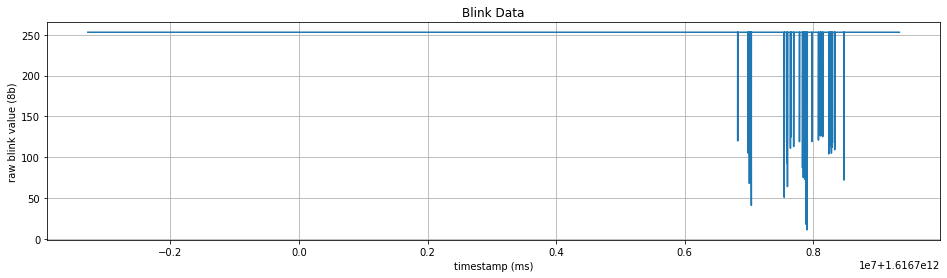

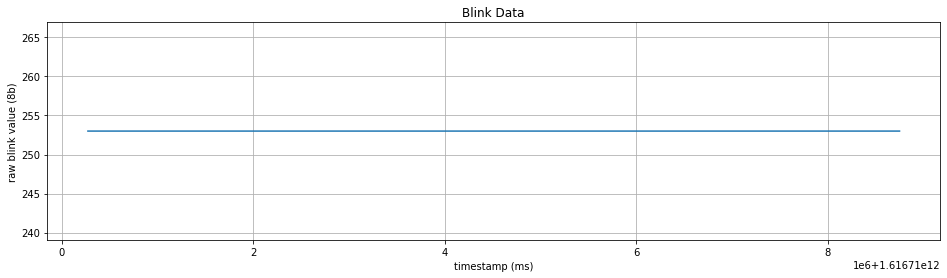

[None, None]

In [16]:
session_day = "03/25"

#get data from that day, sort into sessions
sorted_data = get_packets_by_range(start= session_day+"/21 12:00:00AM EDT")
glasses_data_by_session = create_sessions(sorted_data)
glasses_data_by_session = filter_short_sessions(glasses_data_by_session)
glasses_data_by_session = get_sessions_by_day(glasses_data_by_session, "03/25")

print_session_times(glasses_data_by_session)

#distill out blink data
glasses_blinkdata_sessions = [get_blink_data(d) for d in glasses_data_by_session]
[plot_blink(glasses_blinkdata) for glasses_blinkdata in glasses_blinkdata_sessions]

#pull our video metadata (estimated start time) for that day
vid_start_estimate = video_metadata[session_day]['vid_start']
vid_error = video_metadata[session_day]['start_error_sec']

#load the video file, map the timestamps based on the estimate

#interpolate to glasses samplerate (60 Hz for blink to 1kHz for glasses) 
#16.67X sample rate, or upsample 50x and downsample 3x

